# Data downloaded from [here](https://www.kaggle.com/datasets/overspleen/brats-2020-fixed-355)

All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes.

Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1).


### Code referenced from [this kaggle notebook](https://www.kaggle.com/code/polomarco/brats20-3dunet-3dautoencoder/data)



# This notebook contains the code necessary to train a defined model and save the logs in the `./Logs` folder
# **Instructions**: 
1. Design/modify your model in the models folder and give it a short but descriptive name.
2. Import and instantiate your model in the 2nd cell of this notebook
3. In the 3rd cell  assign "`./Log/{your_model_name}`" to `train_logs_path`. The training
results will be saved to this folder.
4. Run all cells and wait till training is complete.

In [1]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau



import warnings
warnings.simplefilter("ignore")


# Model is defined here

## Models are created/modified in the models folder and imported here before being instantiated

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu118
True


In [2]:
from utils.Meter import Meter, DiceLoss, BCEDiceLoss, dice_coef_metric_per_classes, jaccard_coef_metric_per_classes

from utils.BratsDataset import BratsDataset

from utils.Meter import BCEDiceLoss


from utils.viz_eval_utils import get_dataloaders, compute_scores_per_classes

from models.UNet3d import UNet3d
from models.UNet3dSingleConv import UNet3dSingleConv
from models.UNet3dDropout import UNet3dDropout
from models.SwinUNETR import SwinUNETR
from models.UNet3d_your_modifications import UNet3d_your_modifications
from models.UNet3d_SELU import UNet3d_SELU
from models.UNet3d_atten import UNet3d_atten
from models.ONet3d import ONet3d
from models.ONet3d_v2 import ONet3d_v2
from models.ONet3d_v3 import ONet3d_v3
from models.ONet3d_v3_DoubleConv import ONet3d_v3_DoubleConv
from models.UNet3d_GELU import UNet3d_GELU
from models.ONet3d_v3_GELU import ONet3d_v3_GELU
from models.SphereNet3d import SphereNet3d


######################## DEFINE MODEL HERE##############################
model = ONet3d_v3_GELU(in_channels=4, n_classes=3, n_channels=8).to('cpu')
########################################################################
# model = ONet3d_v3(
#     in_channels=4, n_classes=3, n_channels=32).to('cuda')  # n_channels should be in multiples of num_groups (default 8)
# model = SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(2, 2, 2, 2), num_heads=(2,4,8,16)).to('cuda')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(torch.cuda.is_available())
print(f"Parameter count: {count_parameters(model)}")

print(model)


True
Parameter count: 351651
ONet3d_v3_GELU(
  (conv): DoubleConvTwoOut(
    (DoubleConvTwoOut): Sequential(
      (0): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 8, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 8, eps=1e-05, affine=True)
      (5): GELU(approximate='none')
    )
  )
  (enc1_bot): DownSingle(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): SingleConv(
        (single_conv): Sequential(
          (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 16, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
      )
    )
  )
  (enc2_bot): DownSingle(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

## Global Config class to seed everything and define file paths

### Modify `train_logs_path` to `./Log/{your_model_name}`; results will be saved here 

In [3]:
# Global config class
class GlobalConfig:
    # Global config class
    root_dir = './BraTS2020'
    train_root_dir = './BraTS2020\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
    test_root_dir = './BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
    # CSV where patient ID, path and fold information will be stored
    path_to_csv = './fold_data.csv'
    # Where train log is stored; each row (epoch) consists of train/val loss, dice score and jaccard score.  
    # TO DO: Change this for changes in different hyperparam/Model
    train_logs_path = './Logs/3DUnet_your_modifications'
    pretrained_model_path = './Logs/3DOnet_SingleConv_Kernel1_GELU/your_best_model_20230317-022023.pth'
    # for reproducibility
    seed = 42


def seed_everything(seed: int):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed=seed)


def load_img(file_path):
    data = nib.load(filename=file_path)
    data = np.asarray(a=data.dataobj)
    return data

config = GlobalConfig()
seed_everything(config.seed)
if not os.path.isdir(config.train_logs_path):
    os.mkdir(config.train_logs_path)


# Visualisations

## Display a sample visualisation of patient 10 at slice index 85

### img (features) shape -> (240, 240, 155); mask (label) shape -> (240, 240, 155); corresponding to height, width and depth.

### mask unique -> [0 1 2 4]; corresponds to the background (BG — label 0), necrotic and non-enhancing tumor core (NCR/NET — label 1), the peritumoral edema (ED — label 2) and GD-enhancing tumor (ET — label 4)

### In the BraTS challenge, the segmentation performance is evaluated on three partially overlapping sub-regions of tumors, namely, whole tumor (WT), tumor core (TC), and enhancing tumor (ET). 

### The WT is the union of ED, NCR/NET, and ET (Label 1,2 and 4), while the TC includes NCR/NET and ET (Label 1 and 4). ET only contains label 4. We hence create 3 sets of mask. This will eventually be stacked upon each other during preprocessing in the Dataset Class.

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)
mask unique -> [0 1 2 4]


Text(0.5, 0.98, 'Multimodal Scans of Patient 004 at Slice 85')

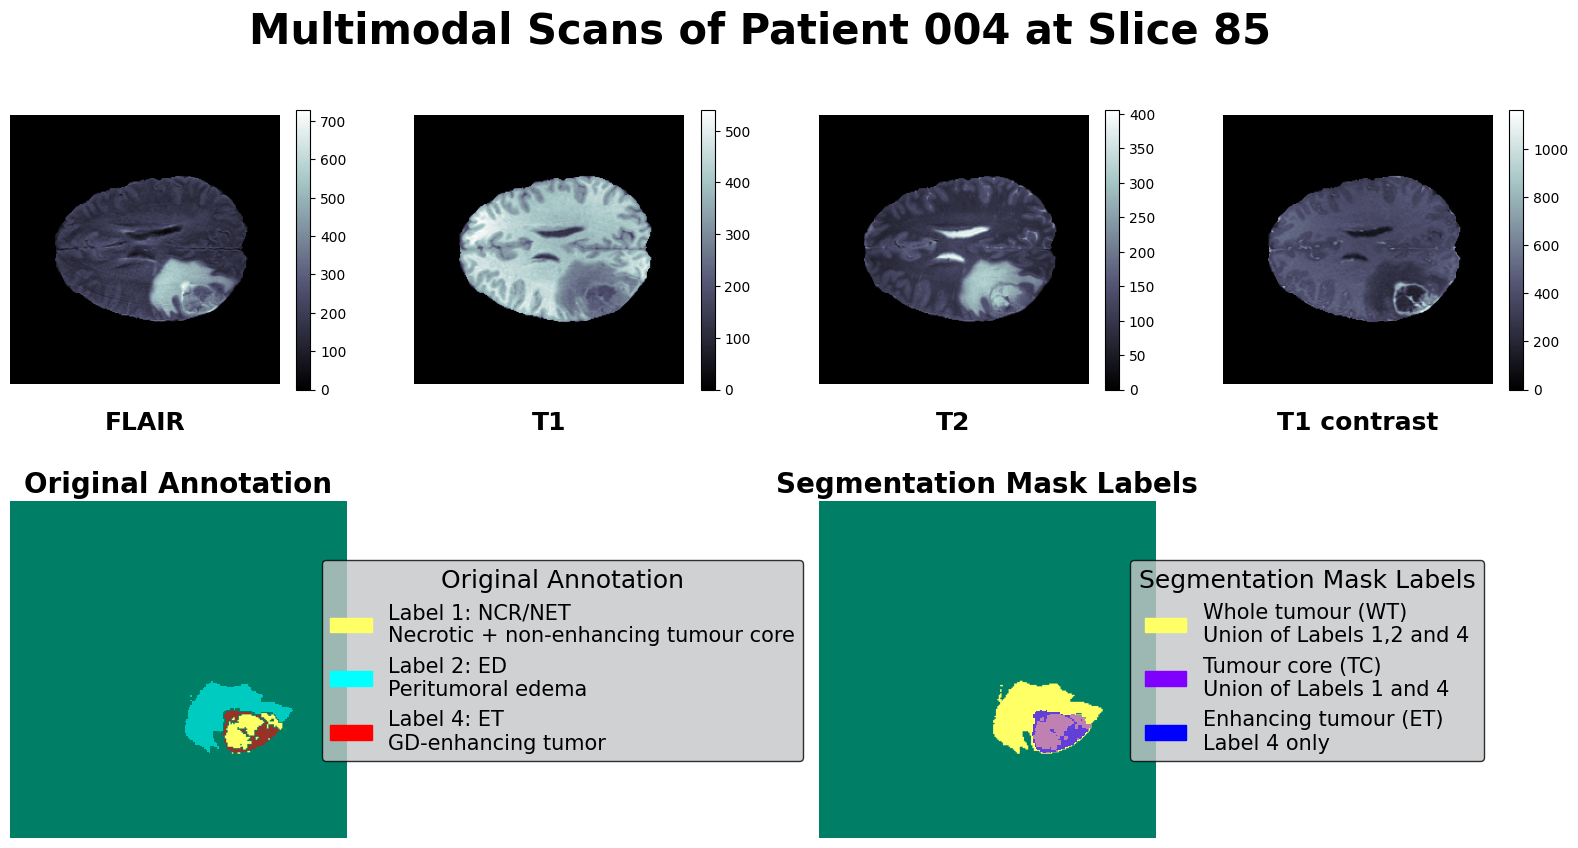

In [4]:
# Change these to visualise brain MRIs of different patients, and at different slices
PATIENT_IDX = 4  # 1 - 369
SLICE_IDX = 85  # 0 - 154


sample_filename = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_flair.nii"
sample_filename_mask = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_seg.nii"

sample_img = load_img(sample_filename)
sample_mask = load_img(sample_filename_mask)

sample_filename2 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1.nii"
sample_img2 = load_img(sample_filename2)

sample_filename3 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t2.nii"
sample_img3 = load_img(sample_filename3)

sample_filename4 = f"{config.train_root_dir}/BraTS20_Training_{PATIENT_IDX:03d}/BraTS20_Training_{PATIENT_IDX:03d}_t1ce.nii"
sample_img4 = load_img(sample_filename4)

# (240, 240, 155), corresponding to height, width and depth
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)
# [0,1,2,4], corresponding to the background (BG — label 0), necrotic and non-enhancing tumor core (NCR/NET — label 1), the peritumoral edema (ED — label 2) and GD-enhancing tumor (ET — label 4)
print("mask unique ->", np.unique(sample_mask))

# In the BraTS challenge, the segmentation performance is evaluated on three partially overlapping sub-regions of tumors,
# namely, whole tumor (WT), tumor core (TC), and enhancing tumor (ET).
# The WT is the union of ED, NCR/NET, and ET, while the TC includes NCR/NET and ET.
# We hence create 3 sets of mask. This will eventually be stacked upon each other during preprocessing in the Dataset Class.
mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

mask_NCR_NET = sample_mask.copy()
mask_NCR_NET[mask_NCR_NET == 1] = 1
mask_NCR_NET[mask_NCR_NET == 2] = 0
mask_NCR_NET[mask_NCR_NET == 4] = 0

mask_ED = sample_mask.copy()
mask_ED[mask_ED == 1] = 0
mask_ED[mask_ED == 2] = 1
mask_ED[mask_ED == 4] = 0


# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib


fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
# Show all columns and rows, but a specific slice index
flair = ax0.imshow(sample_img[:, :, SLICE_IDX], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:, :, SLICE_IDX], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:, :, SLICE_IDX], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:, :, SLICE_IDX], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

ax4 = fig.add_subplot(gs[1, 0:1])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,SLICE_IDX]== False,  mask_WT[:,:,SLICE_IDX]), cmap='summer', alpha=0.6)
j1 = ax4.imshow(mask_NCR_NET[:, :, SLICE_IDX], cmap='summer',)
j2 = ax4.imshow(np.ma.masked_where(
    mask_ED[:, :, SLICE_IDX] == False,  mask_TC[:, :, SLICE_IDX]), cmap='cool', alpha=0.6)
j3 = ax4.imshow(np.ma.masked_where(
    mask_ET[:, :, SLICE_IDX] == False, mask_ET[:, :, SLICE_IDX]), cmap='autumn', alpha=0.6)

ax4.set_title("Original Annotation", fontsize=20, weight='bold')

colors_j = [im.cmap(im.norm(1)) for im in [j1, j2, j3]]
labels_j = ['Label 1: NCR/NET\nNecrotic + non-enhancing tumour core',
            'Label 2: ED\nPeritumoral edema ', 'Label 4: ET\nGD-enhancing tumor ']
patches_j = [mpatches.Patch(
    color=colors_j[i], label=f"{labels_j[i]}") for i in range(len(labels_j))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches_j, bbox_to_anchor=(0.9, 0.85), loc=2, borderaxespad=0.4, fontsize=15,
           title='Original Annotation', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

#  Varying density along a streamline
ax5 = fig.add_subplot(gs[1, 2:3])

#ax5.imshow(np.ma.masked_where(mask_WT[:,:,SLICE_IDX]== False,  mask_WT[:,:,SLICE_IDX]), cmap='summer', alpha=0.6)
l1 = ax5.imshow(mask_WT[:, :, SLICE_IDX], cmap='summer',)
l2 = ax5.imshow(np.ma.masked_where(
    mask_TC[:, :, SLICE_IDX] == False,  mask_TC[:, :, SLICE_IDX]), cmap='rainbow', alpha=0.5)
l3 = ax5.imshow(np.ma.masked_where(
    mask_ET[:, :, SLICE_IDX] == False, mask_ET[:, :, SLICE_IDX]), cmap='winter', alpha=0.5)

ax5.set_title("Segmentation Mask Labels", fontsize=20, weight='bold')

colors_l = [im.cmap(im.norm(1)) for im in [l1, l2, l3]]
labels_l = ['Whole tumour (WT)\nUnion of Labels 1,2 and 4',
            'Tumour core (TC)\nUnion of Labels 1 and 4', 'Enhancing tumour (ET)\nLabel 4 only']
patches_l = [mpatches.Patch(
    color=colors_l[i], label=f"{labels_l[i]}") for i in range(len(labels_l))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches_l, bbox_to_anchor=(0.9, 0.85), loc=2, borderaxespad=0.4, fontsize=15,
           title='Segmentation Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

_ = [ax.set_axis_off() for ax in [ax0, ax1, ax2, ax3, ax4, ax5]]

plt.suptitle(f"Multimodal Scans of Patient {PATIENT_IDX:03} at Slice {SLICE_IDX}",
             fontsize=30, weight='bold')


# Preprocessing

### This cell creates the CSV `fold_data.csv` which contains the information to map different patients (and their directory paths) to different training folds
### Fold 0 will be used as validation set (53 samples)
### Fold 1 will be used as test set (53 samples)
### The rest of the folds (2-6) will be used as training test (263 samples)

In [5]:
survivalInfoPath = f"{config.train_root_dir}/survival_info.csv"
nameMappingPath = f"{config.train_root_dir}/name_mapping.csv"
survival_info_df = pd.read_csv(survivalInfoPath)
name_mapping_df = pd.read_csv(nameMappingPath)

name_mapping_df.rename({'BraTS_2020_subject_ID': 'Brats20ID'}, axis=1, inplace=True) 


df = survival_info_df.merge(name_mapping_df, on="Brats20ID", how="right")
df = df[["Brats20ID"]]
paths = []
for _, row  in df.iterrows():
    
    id_ = row['Brats20ID']
    path = os.path.join(config.train_root_dir, id_)
    paths.append(path)
    
df['path'] = paths

train_data = df

kf = KFold(n_splits=7, random_state=config.seed, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(train_data)):
    # assign all rows at val_index to the ith fold
    train_data.loc[val_index, "fold"] = i


train_data.to_csv(config.path_to_csv, index=False)


# Trainer Class

### Times itself; computes and tracks loss, dice and jaccard score over 50 epochs.
### Tracks and plots loss, dice and jaccard score over the 50 epochs
### Saves best and last checkpoints into filepath defined in config
### Saves train history into filepath defined in config


In [6]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 val_fold: int,
                 test_fold: int,
                 num_epochs: int,
                 path_to_csv: str,
                 display_plot: bool = True,
                 do_resizing: bool = True,
                 optimizer: torch.optim = Adam
                ):

        """Initialization."""
        self.device = 'cpu' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",  # Reduces learning rate when a metric has stopped improving
                                           patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        train_dl, val_dl, test_dl = get_dataloaders(
            dataset=dataset,
            path_to_csv=path_to_csv,
            val_fold=val_fold,
            test_fold=test_fold,
            batch_size=batch_size,
            num_workers=4,
            do_resizing=do_resizing,
        )
        self.dataloaders = {
            "train": train_dl,
            "val": val_dl,
            "test": test_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
        self.last_completed_run_time = None
        self.parameter_count = count_parameters(self.net)
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        # print(f"{phase} epoch: {epoch + 1} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        t_dataloader = tqdm(enumerate(dataloader), unit="batch", total=total_batches)
        for itr, data_batch in t_dataloader:
            t_dataloader.set_description(f"{phase} epoch: {epoch + 1} | time: {time.strftime('%H:%M:%S')}")
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            t_dataloader.set_postfix(loss=loss.item())
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def run(self):
        start = datetime.now()
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                now = datetime.now().strftime("%Y%m%d-%H%M%S")
                checkpoint_filename = f"your_best_model_{now}.pth"
                torch.save(self.net.state_dict(), os.path.join(
                    config.train_logs_path, checkpoint_filename))
            print()
        self.last_completed_run_time = str(datetime.now() - start)
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        now = datetime.now().strftime("%Y%m%d-%H%M%S")
        checkpoint_filename = f"your_last_epoch_model_{now}.pth"
        torch.save(self.net.state_dict(),os.path.join(
            config.train_logs_path, checkpoint_filename))

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        # train_logs_path = './BraTS2020Logs/train_log.csv'
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv(os.path.join(config.train_logs_path, f"train_log_{now}.csv"), index=False)


# Instantiate Trainer class

### Uses Adam optimizer by default
### BCEDiceLoss used; equals 0.5 BCE loss + 0.5 Dice Loss; penalizes both predictions AND confidence
### Load checkpoint here if necessary

In [7]:

DO_RESIZING = True  # Đảm bảo ảnh sẽ được resize nhỏ lại trong Dataset (nếu có thể, hãy kiểm tra kích thước resize trong BratsDataset)

trainer = Trainer(net=model,
                  dataset=BratsDataset,
                  criterion=BCEDiceLoss(),
                  lr=5e-4,
                  accumulation_steps=4,
                  batch_size=1,
                  val_fold=0,
                  test_fold=1,
                  num_epochs=50,
                  path_to_csv=config.path_to_csv,
                  do_resizing=DO_RESIZING,
                  optimizer=Adam)

#######################################################################
# """UNCOMMENT THE FOLLOWING 2 LINES IF RELOADING MODEL CHECKPOINT"""
# if config.pretrained_model_path is not None:
#     trainer.load_predtrain_model(config.pretrained_model_path)
#######################################################################


device: cpu


### Defines the train, val and test dataloaders (only test dataloaders will be used for visualisation later)
### Show size of train, val and test set (263, 53, 53 respectively)

In [8]:
dataloader, _, test_dataloader = get_dataloaders(
    dataset=BratsDataset, path_to_csv=config.path_to_csv, val_fold=0, test_fold=1, batch_size=1, do_resizing=DO_RESIZING)
len(dataloader)

print(len(dataloader))
print(len(_))
print(len(test_dataloader))


263
53
53


### Show structure and shape of dataloader outputs; id, features and labels.

### Features comprise 4 channels, label comprise 3 sets of masks (3 classes)

In [9]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape
# size = (batch_size, channels, depth, width, height)

(['BraTS20_Training_290'],
 torch.Size([1, 4, 128, 224, 224]),
 torch.Size([1, 3, 128, 224, 224]))

### Visualise all 128 slices in the single sample defined above

Num uniq Image values : 401
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([6202244,  220284], dtype=int64))
(128, 224, 224)


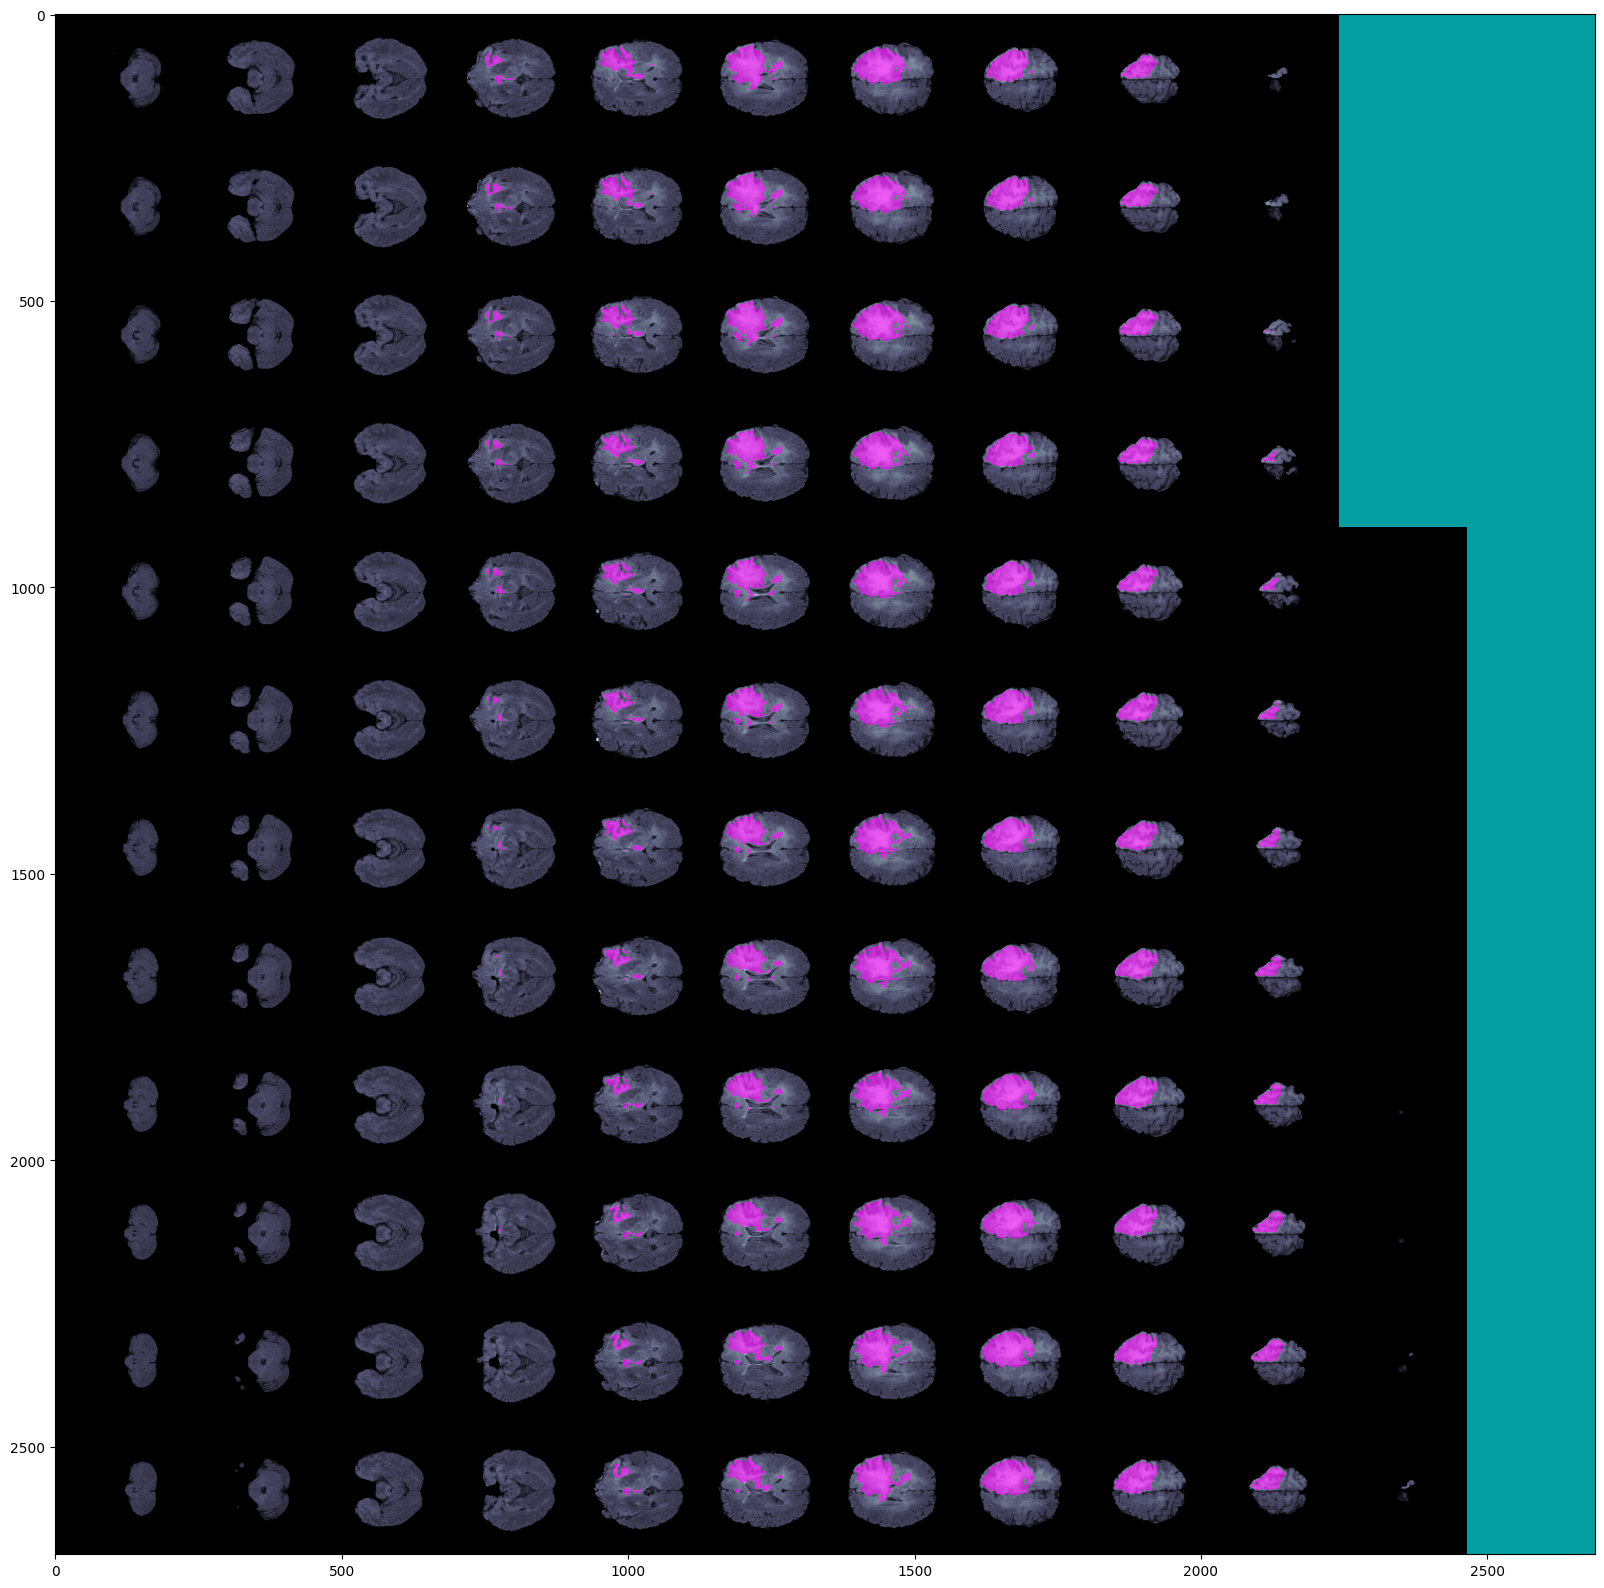

In [10]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))
print(img_tensor.shape)
image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

# Start Training

In [11]:
"""Uncomment these to clear GPU VRAM"""
# del model
torch.cuda.empty_cache()
torch.cuda.synchronize()
# assert(0==1)

In [ ]:
# assert(0==1)
"""UNCOMMENT THIS TO START TRAINING"""
trainer.run()



train epoch: 1 | time: 19:55:51:   6%|▌         | 15/263 [14:57<4:28:39, 65.00s/batch, loss=0.385]


### At this stage, Trainer contains a log of the training process and the tracked loss/results
### The following cell saves trainer properties into the filepath defined by the config class

In [ ]:
# write logs to train_logs_path
with open(os.path.join(config.train_logs_path, 'trainer_properties.txt'), 'w') as f:
  for param, value in trainer.__dict__.items():
      if not param.startswith("__"):
        f.write(f"{param}:{value}\n")


# Evaluation and Results

### Set model to eval mode
### Compute dice and jaccard scores over test dataloader to get preliminary test results

In [ ]:
# %%time
model.eval()
dice_scores_per_classes, iou_scores_per_classes, ids = compute_scores_per_classes(
    model, test_dataloader, ['WT', 'TC', 'ET']
    )

### Display some results for individual samples

In [ ]:
ids_df = pd.DataFrame(ids)
ids_df.columns = ['Ids']

dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
val_metics_df = pd.concat([ids_df, dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['Ids', 'WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard']]
val_metics_df.sample(5)


,Ids,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard
19,BraTS20_Training_017,0.921531,0.854480,0.878334,0.783062,0.793731,0.658005
41,BraTS20_Training_025,0.916297,0.845525,0.941893,0.890168,0.859008,0.752860
47,BraTS20_Training_284,0.938067,0.883358,0.871884,0.772867,0.503193,0.336178
12,BraTS20_Training_228,0.871563,0.772363,0.918668,0.849571,0.887410,0.797607
43,BraTS20_Training_079,0.757589,0.609773,0.865893,0.763502,0.606891,0.435638


### Display and plot preliminary test results

In [ ]:
val_metics_df.mean()


WT dice       0.872517
WT jaccard    0.789336
TC dice       0.682160
TC jaccard    0.578747
ET dice       0.624762
ET jaccard    0.521188
dtype: float64

### Save results to Logs folder

In [ ]:
val_metics_df
pd.DataFrame(val_metics_df).to_csv(os.path.join(
    config.train_logs_path, f"test_results.csv"), index=False)
pd.DataFrame(val_metics_df.mean()).to_csv(os.path.join(
    config.train_logs_path, f"test_results_mean.csv"), index=True)


### Visualise test results

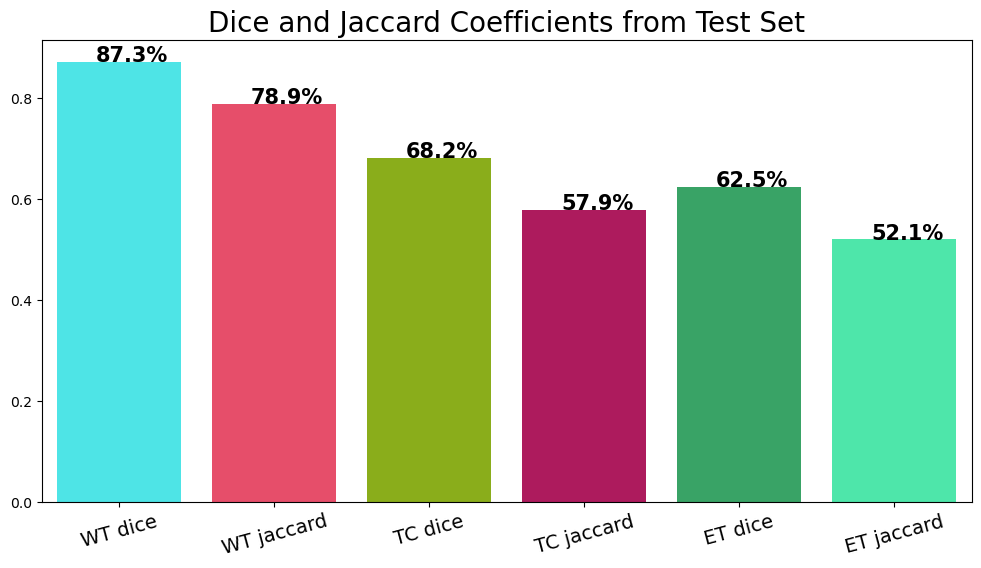

In [ ]:
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard']]

colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax)
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Test Set", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig(os.path.join(config.train_logs_path, "result.png"), format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig(os.path.join(config.train_logs_path, "result.svg"), format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')




### Code producing more visualisations (e.g. model predictions against ground truth) can be found in VizEval_Notebook.ipynb and VizEval_Single_Notebook.ipynb
### Visualizations themselves can be found in the models' respective directories within the Logs folder, under prediction_samples.

# Elucidate and displays model architecture via backpropagation
### Visualisation of model architecture saved in respective directory in the Logs folder 

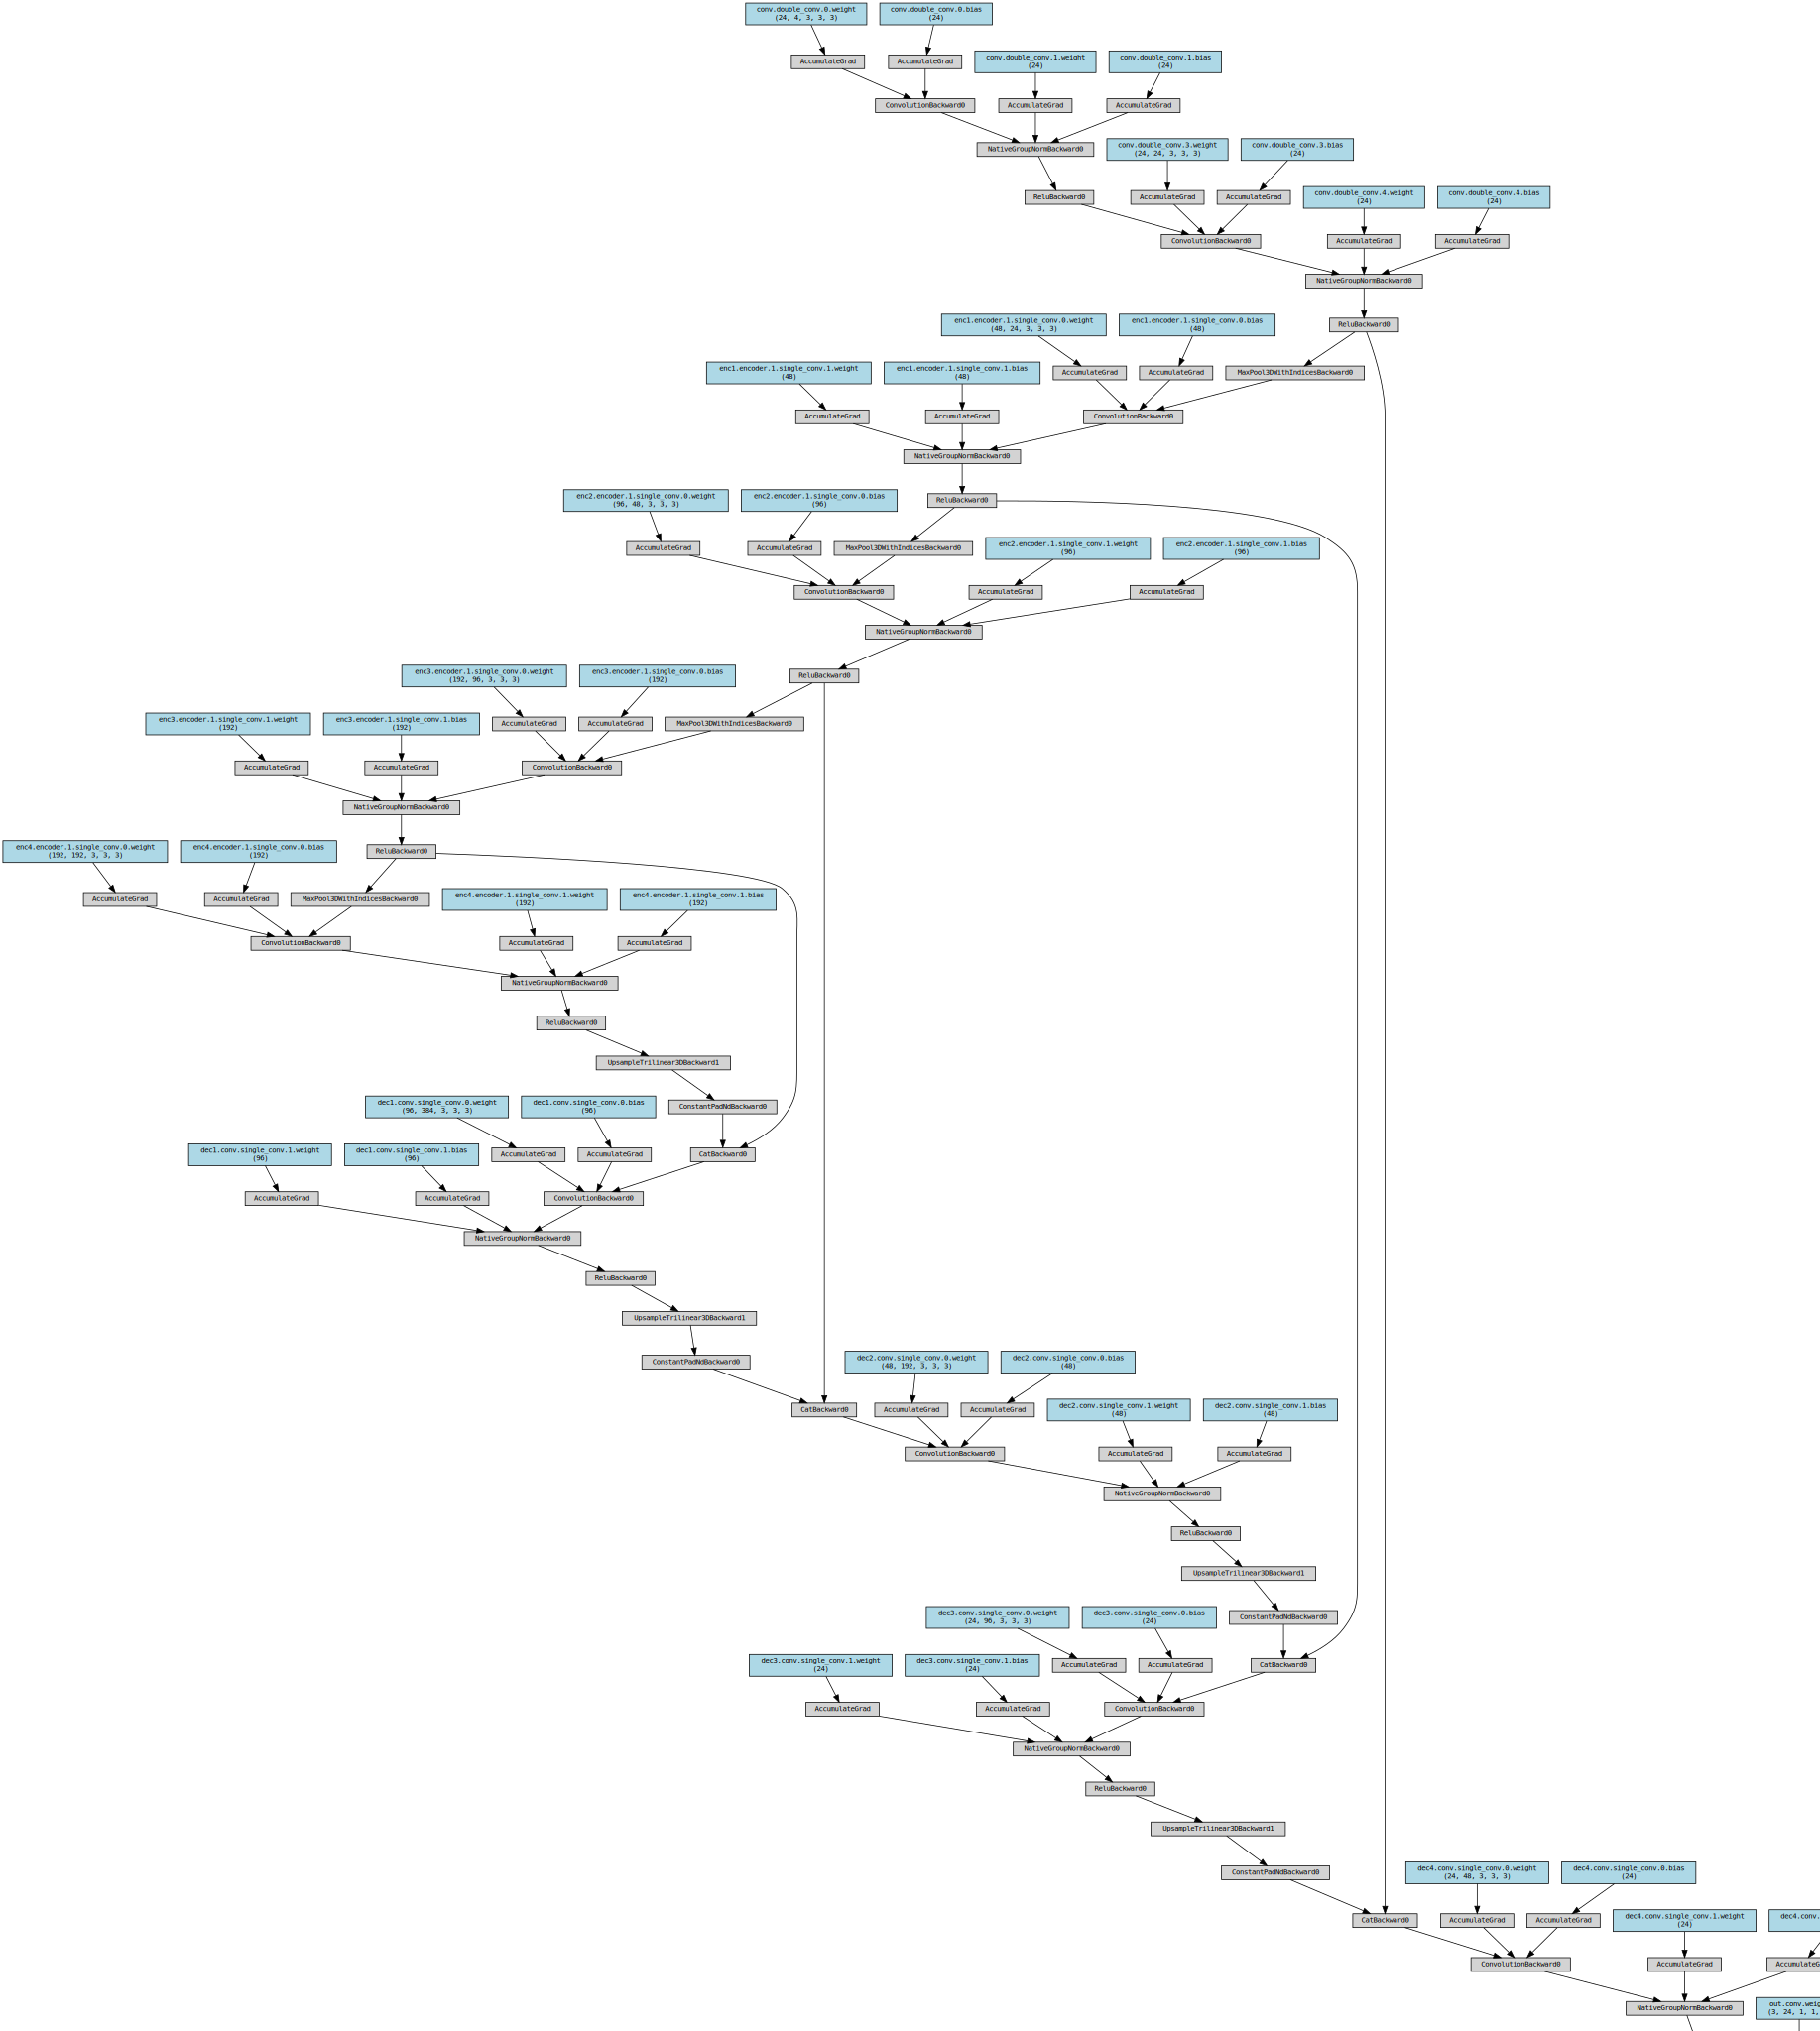

In [ ]:
from torchviz import make_dot
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# with torch.no_grad():
data = next(iter(test_dataloader))
id_, imgs, targets = data['Id'], data['image'], data['mask']
imgs, targets = imgs.to(device), targets.to(device)
logits = model(imgs)
graph = make_dot(logits, params=dict(model.named_parameters()))
graph


In [ ]:
graph.render(os.path.join(config.train_logs_path, "model"), format="png")


'Logs/3DUnet_SingleConv/model.png'